### Create Train and Test Datasets
---

This notebook loads a dataset from synthetic neural activity signals then splits it equal halves train and test datasets.
 
We then plot sequences from the two halves to see if they are organized correctly for next-timestep sequence-to-sequence prediction.

#### Libraries
---

In [5]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils import NEURONS_302
from data._utils import create_combined_dataset, split_combined_dataset

# Silence warnings
warnings.filterwarnings("ignore", category=FutureWarning)

#### Create datasets
---

In [6]:
# Create a single combined dataset
# datasets = dict(Sines0000="all")  # a synthetic neural dataset (1 worm)
# datasets = dict(Lorenz0000="all")  # a synthetic neural dataset (1 worm)
datasets = dict(Uzel2022=1)  # a real worm neural dataset (1 worm)
combined_dataset, dataset_info = create_combined_dataset(
    datasets, num_named_neurons=None
)
num_worms = len(combined_dataset)

# Split the datsaet into train and validation halves
num_train_samples = num_val_samples = num_samples = 2
reverse = use_residual = False
smooth_data = True
seq_len = 500
train_dataset, val_dataset, timestep_info = split_combined_dataset(
    combined_dataset,
    num_train_samples,
    num_val_samples,
    seq_len,
    reverse,
    use_residual,
    smooth_data,
)

#### Sample train and test sequences
---

In [7]:
# NOTE: The last train sample comes right before the first test sample.

# Get the sample from the train dataset
X_train, Y_train, mask_train, meta_train = train_dataset[-1]
num_neurons_train = mask_train.sum().item()
time_train = meta_train["time_vec"]
print(
    f"\nX:{X_train.shape}\nY:{Y_train.shape}\nmask:{mask_train.shape}\ntime:{time_train.shape}"
)

# Get the sample from the validation dataset
X_test, Y_test, mask_test, meta_test = val_dataset[0]
num_neurons_test = mask_test.sum().item()
time_test = meta_test["time_vec"]
print(
    f"\nX:{X_test.shape}\nY:{Y_test.shape}\nmask:{mask_test.shape}\ntime:{time_test.shape}"
)


X:torch.Size([500, 302])
Y:torch.Size([500, 302])
mask:torch.Size([302])
time:torch.Size([500])

X:torch.Size([500, 302])
Y:torch.Size([500, 302])
mask:torch.Size([302])
time:torch.Size([500])


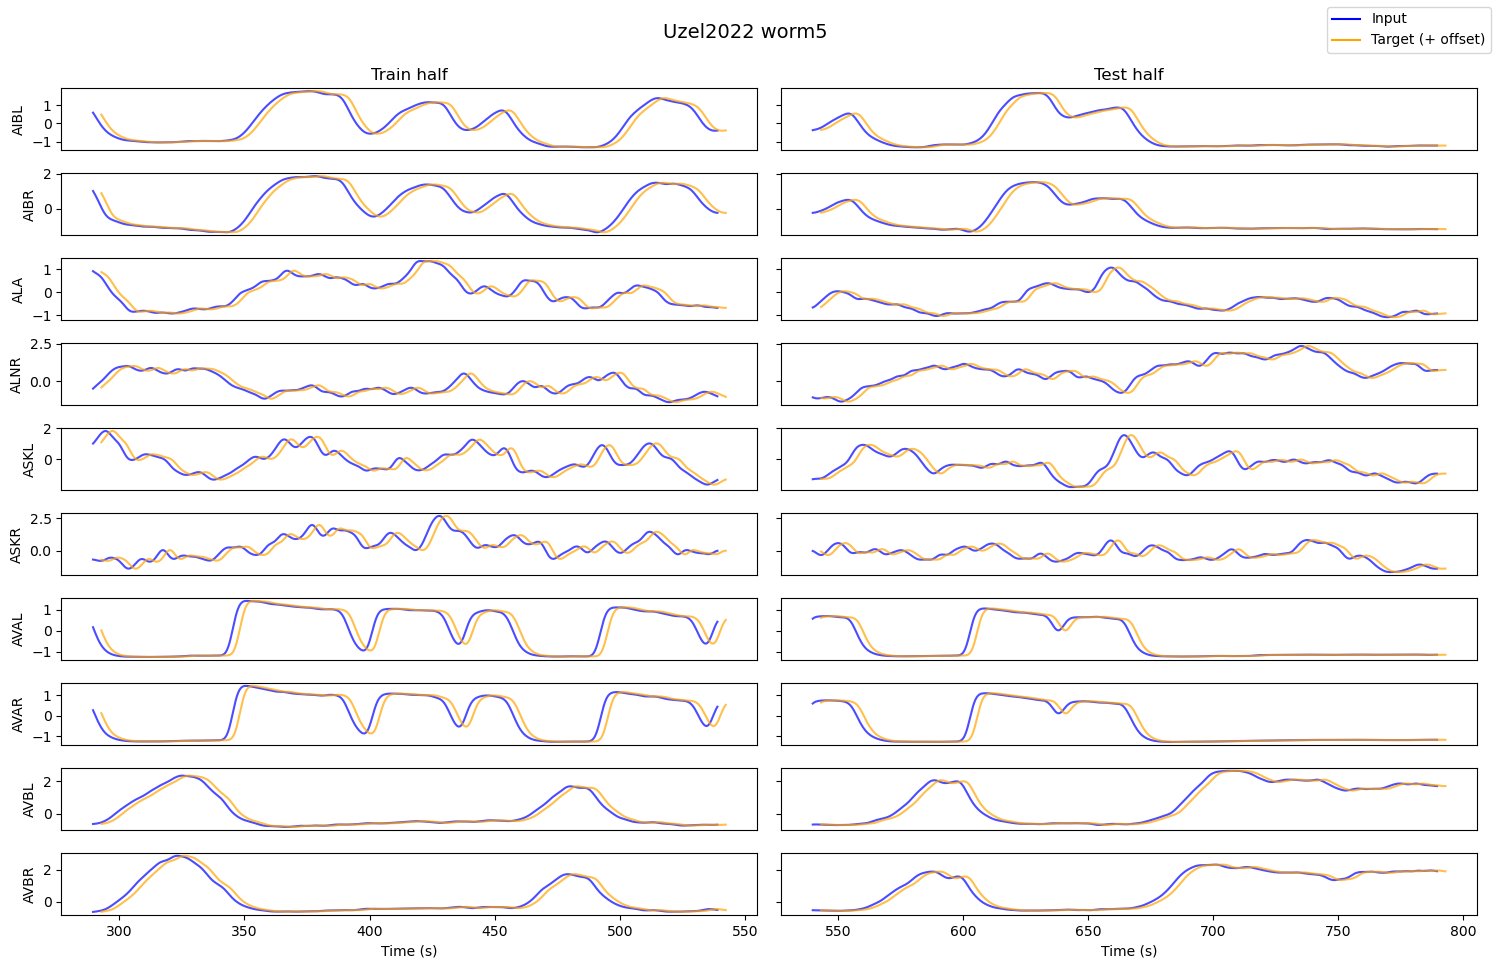

In [8]:
# Set up the matplotlib figure for two columns of subplots
max_neurons_to_plot = 10
num_neurons = min(max_neurons_to_plot, num_neurons_train, num_neurons_test)
fig, axes = plt.subplots(num_neurons, 2, figsize=(15, 10), sharey="row")

# Plot data for each half
for col, phase in enumerate(["train", "test"]):
    # Convert the data to NumPy arrays if they are not already
    time = eval(f"time_{phase}.numpy()")
    X = eval(f"X_{phase}.numpy()")
    Y = eval(f"Y_{phase}.numpy()")
    mask = eval(f"mask_{phase}.numpy()")
    worm_dataset = eval(f"meta_{phase}['worm_dataset']")
    wormID = eval(f"meta_{phase}['wormID']")

    # Set offsets for the target data
    y_offset_step = 5
    x_offset = len(time) / 150

    # Get the indices of the neurons to plot
    neurons_to_plot = np.where(mask)[0][:num_neurons]

    data_fragments = []

    for i, neuron_idx in enumerate(neurons_to_plot):
        neuron_label = NEURONS_302[neuron_idx]

        # Collect input data
        input_df = pd.DataFrame(
            {
                "Time": time,
                "Value": X[:, neuron_idx],
                "Type": "Input",
                "Neuron": neuron_label,
            }
        )
        data_fragments.append(input_df)

        # Collect target data with time offset
        target_df = pd.DataFrame(
            {
                "Time": time
                + x_offset,  # Adjust the time if needed for display purposes
                "Value": Y[:, neuron_idx],
                "Type": "Target (+ offset)",
                "Neuron": neuron_label,
            }
        )
        data_fragments.append(target_df)

    # Concatenate all fragments to create the full DataFrame
    df = pd.concat(data_fragments, ignore_index=True)

    # Plot the lines
    for i, neuron_label in enumerate(neurons_to_plot):
        sns.lineplot(
            data=df[df["Neuron"] == NEURONS_302[neuron_label]],
            x="Time",
            y="Value",
            hue="Type",
            ax=axes[i, col],
            palette=["blue", "orange"],
            alpha=0.7,
        )
        axes[i, col].set_ylabel(NEURONS_302[neuron_label])
        axes[i, col].get_legend().remove()

        # Set the x-axis label to empty
        axes[i, col].set_xlabel("")

        # Hide x-axis labels and ticks for all but the last row
        if i < num_neurons - 1:
            axes[i, col].set_xticklabels([])
            axes[i, col].set_xticks([])
        else:
            axes[i, col].set_xlabel("Time (s)")

        # Set title only for the first row of each column
        if i == 0:
            axes[i, col].set_title(f"{phase.capitalize()} half")
        else:
            axes[i, col].set_title("")

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display name of dataset and worm as suptitle
fig.suptitle(f"{worm_dataset} {wormID}", fontsize=14)

# Display the legend outside the rightmost plot
handles, labels = axes[0, -1].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")

plt.show()